In [2]:
import pickle
import pandas as pd
import numpy as np
import pickle

from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import warnings
import tensorflow as tf
import seaborn as sns
import sklearn
import random
import math
import time


from tensorflow.keras.callbacks import ReduceLROnPlateau
from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, GRU
from scipy import optimize
from tensorflow.keras import optimizers


from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *
from methods import *

%matplotlib inline
warnings.filterwarnings('ignore')

SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Appeler la fonction pour fixer le seed
set_seed(SEED)

### Data loading

In [31]:
def min_max_normalize_rul_by_bearing(data, rul_col='RUL', bearing_col='bearing_id'):
    """
    Effectue une normalisation Min-Max du RUL pour chaque roulement (bearing_id).

    :param data: DataFrame contenant les colonnes `bearing_col` et `rul_col`.
    :param rul_col: Nom de la colonne contenant le RUL brut.
    :param bearing_col: Nom de la colonne contenant les identifiants des roulements.
    :return: DataFrame avec une colonne `RUL_norm` ajoutée.
    """
    # data['RUL_norm'] = data.groupby(bearing_col)[rul_col].transform(
    #     lambda x: round((x - x.min()) / (x.max() - x.min()), 3)
    # )
    data['RUL_norm'] = data.groupby(bearing_col)[rul_col].transform(
        lambda x: round((x) / (x.max()), 4)
    )
    return data

def create_sequences(data, target_col, sequence_length, remaining_feature):
    """
    Transforme les données en séquences pour les modèles séquentiels.
    :param data: DataFrame trié par temps et bearing_id
    :param target_col: Nom de la colonne cible (RUL)
    :param sequence_length: Longueur de chaque séquence
    :return: Arrays pour X (features) et y (targets)
    """
    X, y = [], []
    for _, group in data.groupby('bearing_id'):  
        targets = group[target_col].values
        col_to_drop = [col for col  in group.columns if col not in remaining_feature]
        group_values = group.drop(columns=col_to_drop).values
        for i in range(len(group_values) - sequence_length):
            X.append(group_values[i:i + sequence_length])
            y.append(targets[i + sequence_length])
    return np.array(X), np.array(y)

def normalize_features_by_bearing(data, feature_cols, bearing_col='bearing_id'):
    """
    Normalise les colonnes des caractéristiques (features) par roulement en utilisant Min-Max.

    :param data: DataFrame contenant les colonnes des caractéristiques et des roulements.
    :param feature_cols: Liste des colonnes des caractéristiques à normaliser.
    :param bearing_col: Nom de la colonne contenant les identifiants des roulements.
    :return: DataFrame avec les colonnes normalisées.
    """
    # Appliquer la normalisation Min-Max à chaque colonne de caractéristiques
    for col in feature_cols:
        data[col] = data.groupby(bearing_col)[col].transform(
            lambda x: (x - x.min()) / (x.max() - x.min())
        )
    return data

def prep_data(train, val, test, remaining_sensors, alpha, drop = True, drop_sensors=None):
    # if drop:
    #     X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
    #     X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))
    # else:
    #     X_train_interim = train.rename(columns={'bearing_id': 'op_cond'})
    #     X_test_interim = test.rename(columns={'bearing_id': 'op_cond'})

    X_train_interim = train.rename(columns={'bearing_id': 'op_cond'})
    X_val_interim = val.rename(columns={'bearing_id': 'op_cond'})
    X_test_interim = test.rename(columns={'bearing_id': 'op_cond'})

    
    X_train_interim, X_val_interim, X_test_interim = condition_scaler(X_train_interim, X_val_interim, X_test_interim, remaining_sensors)
    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha)
    X_val_interim = exponential_smoothing(X_val_interim, remaining_sensors, 0, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha)
    
    return X_train_interim, X_val_interim, X_test_interim

def rul_piecewise_fct(X_train, rul):
    
    X_train['RUL'].clip(upper=rul, inplace=True)
    
    return X_train

def condition_scaler(df_train, df_val, df_test, sensor_names):
      # apply operating condition specific scaling
  #scaler = StandardScaler()
    scaler = StandardScaler()
    # for condition in df_train['op_cond'].unique():
    scaler.fit(df_train.loc[:, sensor_names])
    
    df_train.loc[:, sensor_names] = scaler.transform(df_train.loc[:, sensor_names])
    df_val.loc[:, sensor_names] = scaler.transform(df_val.loc[:, sensor_names])
    df_test.loc[:, sensor_names] = scaler.transform(df_test.loc[:, sensor_names])
    
    return df_train, df_val, df_test

def exponential_smoothing(df, sensors, n_samples, alpha=0.2):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    new_column = df.groupby('op_cond')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    df[sensors] = new_column.reset_index(level=0, drop=True)


    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result

    mask = df.groupby('op_cond')['op_cond'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]

    return df


In [4]:
remaining_feature = [
    "max_abs_h", "moment_11_v", "mean_freq_freq_h", "crest_factor_freq_freq_h", "energy_band_0_freq_h",
    "rms_freq_freq_v", "crest_factor_freq_freq_v", "peak_freq_freq_v", "integral_energy_h",
    "imf_energy_2_tf_h", "imf_rms_3_tf_h", "imf_rms_1_tf_v", "imf_energy_2_tf_v", "imf_rms_3_tf_v",
    "energy_v", "derivative_rms_h", "derivative_margin_factor_h", "derivative_moment_9_h",
    "derivative_mean_v", "derivative_rms_v", "derivative_margin_factor_v", "derivative_moment_7_v", "derivative_moment_8_v",
    "mean_h", "integral_peak_to_peak_h", "integral_rms_h", "integral_form_factor_h", "crest_factor_h",
    "moment_11_h", "integral_moment_9_h", "integral_max_abs_v", "integral_form_factor_v", "integral_crest_factor_v",
    "imf_energy_0_tf_v", "integral_moment_8_v", "integral_moment_7_v"
]
remaining_feature_idx = [
    "max_abs_h", "moment_11_v", "mean_freq_freq_h", "crest_factor_freq_freq_h", "energy_band_0_freq_h",
    "rms_freq_freq_v", "crest_factor_freq_freq_v", "peak_freq_freq_v", "integral_energy_h",
    "imf_energy_2_tf_h", "imf_rms_3_tf_h", "imf_rms_1_tf_v", "imf_energy_2_tf_v", "imf_rms_3_tf_v",
    "energy_v", "derivative_rms_h", "derivative_margin_factor_h", "derivative_moment_9_h",
    "derivative_mean_v", "derivative_rms_v", "derivative_margin_factor_v", "derivative_moment_7_v", "derivative_moment_8_v",
    "mean_h", "integral_peak_to_peak_h", "integral_rms_h", "integral_form_factor_h", "crest_factor_h",
    "moment_11_h", "integral_moment_9_h", "integral_max_abs_v", "integral_form_factor_v", "integral_crest_factor_v",
    "imf_energy_0_tf_v", "integral_moment_8_v", "integral_moment_7_v", 'bearing_id']

remaining_feature_rul = [
    "max_abs_h", "moment_11_v", "mean_freq_freq_h", "crest_factor_freq_freq_h", "energy_band_0_freq_h",
    "rms_freq_freq_v", "crest_factor_freq_freq_v", "peak_freq_freq_v", "integral_energy_h",
    "imf_energy_2_tf_h", "imf_rms_3_tf_h", "imf_rms_1_tf_v", "imf_energy_2_tf_v", "imf_rms_3_tf_v",
    "energy_v", "derivative_rms_h", "derivative_margin_factor_h", "derivative_moment_9_h",
    "derivative_mean_v", "derivative_rms_v", "derivative_margin_factor_v", "derivative_moment_7_v", "derivative_moment_8_v",
    "mean_h", "integral_peak_to_peak_h", "integral_rms_h", "integral_form_factor_h", "crest_factor_h",
    "moment_11_h", "integral_moment_9_h", "integral_max_abs_v", "integral_form_factor_v", "integral_crest_factor_v",
    "imf_energy_0_tf_v", "integral_moment_8_v", "integral_moment_7_v", 'bearing_id', 'window_index', 'RUL_norm']

In [5]:
nom_fichier = "df_training.pkl"

with open(nom_fichier, "rb") as fichier:
    list_df_training = pickle.load(fichier)
    
    nom_fichier = "df_validation.pkl"

with open(nom_fichier, "rb") as fichier:
    list_df_validation = pickle.load(fichier)
    
nom_fichier = "df_test.pkl"

with open(nom_fichier, "rb") as fichier:
    list_df_test = pickle.load(fichier)

In [6]:
nom_fichier = "df_training_rul.pkl"

with open(nom_fichier, "rb") as fichier:
    list_df_training_rul = pickle.load(fichier)
    
nom_fichier = "df_validation_rul.pkl"

with open(nom_fichier, "rb") as fichier:
    list_df_validation_rul = pickle.load(fichier)
    
nom_fichier = "df_test_rul.pkl"

with open(nom_fichier, "rb") as fichier:
    list_df_test_rul = pickle.load(fichier)

### Data preprocessing 

In [7]:
df_train_merged = pd.concat(list_df_training[0:2], ignore_index=True)
df_validation_merged = pd.concat(list_df_validation[0:2], ignore_index=True)
df_test_merged =pd.concat(list_df_test[0:2], ignore_index=True)

df_train_merged_rul = pd.concat(list_df_training_rul[0:2], ignore_index=True)
df_validation_merged_rul = pd.concat(list_df_validation_rul[0:2], ignore_index=True)
df_test_merged_rul =pd.concat(list_df_test_rul[0:2], ignore_index=True)

df_train_merged['RUL'] = df_train_merged_rul['RUL']
df_validation_merged['RUL'] = df_validation_merged_rul['RUL']
df_test_merged['RUL'] = df_test_merged_rul['RUL']

df_train_merged = min_max_normalize_rul_by_bearing(df_train_merged)[remaining_feature_rul]
df_validation_merged = min_max_normalize_rul_by_bearing(df_validation_merged)[remaining_feature_rul]
df_test_merged = min_max_normalize_rul_by_bearing(df_test_merged)[remaining_feature_rul]

In [47]:
# Liste des colonnes de caractéristiques à normaliser (exclure les colonnes de contexte comme 'RUL', 'bearing_id', etc.)
# feature_columns = remaining_feature
# df_train_merged = normalize_features_by_bearing(df_train_merged, feature_cols=feature_columns, bearing_col='bearing_id')
# df_validation_merged = normalize_features_by_bearing(df_validation_merged, feature_cols=feature_columns, bearing_col='bearing_id')
# df_test_merged = normalize_features_by_bearing(df_test_merged, feature_cols=feature_columns, bearing_col='bearing_id')

In [7]:
# Créer des séquences pour l’entraînement et la validation
# X_train_interim, X_val_interim, X_test_interim = prep_data(train=df_train_merged[remaining_feature_idx],
#                                                            val=df_validation_merged[remaining_feature_idx], 
#                                             test=df_test_merged[remaining_feature_idx], 
#                                             remaining_sensors=remaining_feature, 
#                                             alpha=0.1, drop=False)
# X_train_interim.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_train_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]
# X_val_interim.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_validation_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]
# X_test_interim.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_test_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]

# X_train_interim = X_train_interim.astype('float32')
# X_val_interim = X_val_interim.astype('float32')
# X_test_interim = X_test_interim.astype('float32')

# # TW values : 5 feng et al ; 35 Jie Liu 2023 ; 226 Martin et al. 2023
# list_sequences_length = [5, 35, 256]
# SEQUENCE_LENGTH = 35
# X_train, y_train = create_sequences(X_train_interim, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH,
#                                     remaining_feature=remaining_feature)

# # Créer des séquences pour les données de test indépendantes
# X_val, y_val = create_sequences(X_val_interim, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH,
#                                 remaining_feature=remaining_feature)

# # Créer des séquences pour les données de test indépendantes
# X_test, y_test = create_sequences(X_test_interim, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH, 
#                                   remaining_feature=remaining_feature)


In [10]:
# 1layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


def model_lstm_1layer(input_shape, nodes_per_layer, dropout, activation):
    
    cb = keras.callbacks.EarlyStopping(monitor='loss', patience=4)
    model = Sequential()
    model.add(LSTM(units = nodes_per_layer, activation=activation, 
                  input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2))
    # model.add(Dropout(dropout))
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(0.01)))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=0.001))
    # model.save_weights(weights_file)

    return model

In [10]:
# Lower alpha's perform better, so we can ditch a few high ones to reduce the search space
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)

sequence_list = list(np.arange(10,40+1,5))
list_sequences_length = [5, 20, 35, 40, 45, 50]
epoch_list = list(np.arange(5,20+1,5))
nodes_list = [[32], [64], [128], [256]]

# lowest dropout=0.1, because I know zero dropout will yield better training results but worse generalization
dropouts = list(np.arange(1,4)/10)  

# again, earlier testing revealed relu performed significantly worse, so I removed it from the options
activation_functions = ['tanh', 'relu']
batch_size_list = [32, 64, 128, 256, 512]
# sensor_list = [sensor_names]

tuning_options = np.prod([len(alpha_list),
                          len(sequence_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list),
                        #   len(sensor_list)
                        ])
                        #  )
tuning_options

26880

In [11]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 21	13.768992	0.0	3.830708e+02	0.0	189.585159	0.0	0.10	[128]	0.2	tanh	64	30
results001 = pd.DataFrame()

for SEED in range(100):  
    set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    
    alpha = random.sample(alpha_list, 1)[0]
    epochs = 10
    SEQUENCE_LENGTH = random.sample(list_sequences_length, 1)[0]
    nodes_per_layer = random.sample(nodesl_ist, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    
    # create model
    # Data prepration
    # Créer des séquences pour l’entraînement et la validation
    X_train_interim, X_val_interim, X_test_interim = prep_data(train=df_train_merged[remaining_feature_idx],
                                                            val=df_validation_merged[remaining_feature_idx], 
                                                test=df_test_merged[remaining_feature_idx], 
                                                remaining_sensors=remaining_feature, 
                                                alpha=alpha, drop=False)
    X_train_interim.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_train_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]
    X_val_interim.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_validation_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]
    X_test_interim.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_test_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]

    X_train_interim = X_train_interim.astype('float32')
    X_val_interim = X_val_interim.astype('float32')
    X_test_interim = X_test_interim.astype('float32')

    # TW values : 5 feng et al ; 35 Jie Liu 2023 ; 226 Martin et al. 2023
    X_train, y_train = create_sequences(X_train_interim, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH,
                                        remaining_feature=remaining_feature)
    X_train, y_train = X_train.astype(np.float32), y_train.astype(np.float32)

    # Créer des séquences pour les données de test indépendantes
    X_val, y_val = create_sequences(X_val_interim, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH,
                                    remaining_feature=remaining_feature)

    # Créer des séquences pour les données de test indépendantes
    X_test, y_test = create_sequences(X_test_interim, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH, 
                                    remaining_feature=remaining_feature)
    # SEQUENCE_LENGTH = list_sequence_length[i]
    input_shape = (SEQUENCE_LENGTH, len(remaining_feature))    
    print(X_train.shape, y_train.shape, X_test.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Callback pour ajuster le learning rate
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[reduce_lr],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(X_test)
        R2_val.append(r2_score(y_test, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(y_test, y_hat_val_split)))
        # score_val.append(compute_s_score(y_test, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
        #  'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : SEQUENCE_LENGTH, 
         'time': training_time,
         'alpha':alpha}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results001 = pd.concat([results001, pd.DataFrame(d, index=[0])], ignore_index=True)

In [168]:
results001.sort_values(by='RMSE')

,RMSE,std_RMSE,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time,alpha
1,0.236384,0.0,0.054262,0.0,[32],0.2,tanh,256,45,1284.934819,0.10
3,0.246723,0.0,0.057093,0.0,[64],0.2,relu,512,45,1836.827055,0.20
4,0.252030,0.0,0.063039,0.0,[32],0.3,relu,256,35,1049.871721,0.20
0,0.261015,0.0,0.066036,0.0,[32],0.2,relu,256,40,958.484885,0.50
6,0.266290,0.0,0.067172,0.0,[128],0.1,tanh,64,40,5483.436544,0.05
7,0.279152,0.0,0.074441,0.0,[256],0.3,tanh,32,20,11511.025913,0.40
5,0.287251,0.0,0.076834,0.0,[128],0.3,tanh,256,50,4831.998078,0.30
2,0.418006,0.0,0.143353,0.0,[32],0.2,tanh,128,5,473.955136,0.01


In [11]:
def model_lstm_1layer(input_shape, nodes_per_layer, dropout, activation):
    
    cb = keras.callbacks.EarlyStopping(monitor='loss', patience=4)
    model = Sequential()
    model.add(LSTM(units = nodes_per_layer, activation=activation, 
                  input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2))
    # model.add(Dropout(dropout))
    # model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(0.01)))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=0.01))
    # model.save_weights(weights_file)

    return model

In [17]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# RMSE	std_RMSE	MSE	std_MSE	nodes	dropout	activation	batch_size	TW	time
# 0.236431	0.0	0.054317	0.0	[32]	0.2	tanh	256	40	973.954071
results001 = pd.DataFrame()

if True:
    SEED = 1   
    set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    
    alpha = 0.10
    epochs = 25
    SEQUENCE_LENGTH = 45
    nodes_per_layer = [32]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 256
    
    # create model
    # Data prepration
    # Créer des séquences pour l’entraînement et la validation
    X_train_interim, X_val_interim, X_test_interim = prep_data(train=df_train_merged[remaining_feature_idx],
                                                            val=df_validation_merged[remaining_feature_idx], 
                                                test=df_test_merged[remaining_feature_idx], 
                                                remaining_sensors=remaining_feature, 
                                                alpha=alpha, drop=False)
    X_train_interim.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_train_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]
    X_val_interim.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_validation_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]
    X_test_interim.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_test_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]

    X_train_interim = X_train_interim.astype('float32')
    X_val_interim = X_val_interim.astype('float32')
    X_test_interim = X_test_interim.astype('float32')

    # TW values : 5 feng et al ; 35 Jie Liu 2023 ; 226 Martin et al. 2023
    X_train, y_train = create_sequences(X_train_interim, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH,
                                        remaining_feature=remaining_feature)
    X_train, y_train = X_train.astype(np.float32), y_train.astype(np.float32)

    # Créer des séquences pour les données de test indépendantes
    X_val, y_val = create_sequences(X_val_interim, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH,
                                    remaining_feature=remaining_feature)

    # Créer des séquences pour les données de test indépendantes
    X_test, y_test = create_sequences(X_test_interim, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH, 
                                    remaining_feature=remaining_feature)
    # SEQUENCE_LENGTH = list_sequence_length[i]
    input_shape = (SEQUENCE_LENGTH, len(remaining_feature))    
    print(X_train.shape, y_train.shape, X_test.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Callback pour ajuster le learning rate
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        # weights_file = model.get_weights()
        # model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[reduce_lr, early_stopping],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(X_test)
        R2_val.append(r2_score(y_test, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(y_test, y_hat_val_split)))
        # score_val.append(compute_s_score(y_test, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
        #  'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : SEQUENCE_LENGTH, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results001 = pd.concat([results001, pd.DataFrame(d, index=[0])], ignore_index=True)

(775214, 45, 36) (775214,) (971444, 45, 36)
Epoch 1/25
3029/3029 [==============================] - 303s 99ms/step - loss: 0.0593 - val_loss: 0.0585 - lr: 0.0010
Epoch 2/25
3029/3029 [==============================] - 268s 89ms/step - loss: 0.0571 - val_loss: 0.0581 - lr: 0.0010
Epoch 3/25
3029/3029 [==============================] - 266s 88ms/step - loss: 0.0569 - val_loss: 0.0584 - lr: 0.0010
Epoch 4/25
3029/3029 [==============================] - 272s 90ms/step - loss: 0.0546 - val_loss: 0.0553 - lr: 0.0010
Epoch 5/25
3029/3029 [==============================] - 263s 87ms/step - loss: 0.0522 - val_loss: 0.0545 - lr: 0.0010
Epoch 6/25
3029/3029 [==============================] - 256s 84ms/step - loss: 0.0512 - val_loss: 0.0546 - lr: 0.0010
Epoch 7/25
3029/3029 [==============================] - 272s 90ms/step - loss: 0.0507 - val_loss: 0.0563 - lr: 0.0010
Epoch 8/25
3029/3029 [==============================] - 260s 86ms/step - loss: 0.0501 - val_loss: 0.0568 - lr: 0.0010
Epoch 9/25
3

In [18]:
results001.sort_values(by='RMSE')

,RMSE,std_RMSE,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,0.228175,0.0,0.057374,0.0,[32],0.2,tanh,256,45,2845.446275


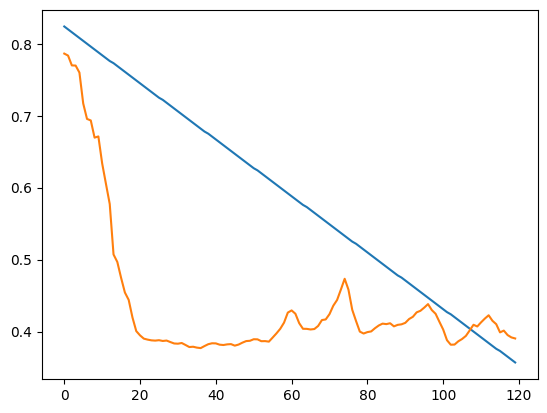

In [19]:
plt.plot(y_test[:120])
plt.plot(y_hat_val_split[:120])

In [22]:
rmse = np.sqrt(mean_squared_error(y_test, y_hat_val_split))
r2 = r2_score(y_test, y_hat_val_split)
print(f"RMSE : '{rmse}', R2 : '{r2}'")

RMSE : '0.22817501425743103', R2 : '0.08749568462371826'


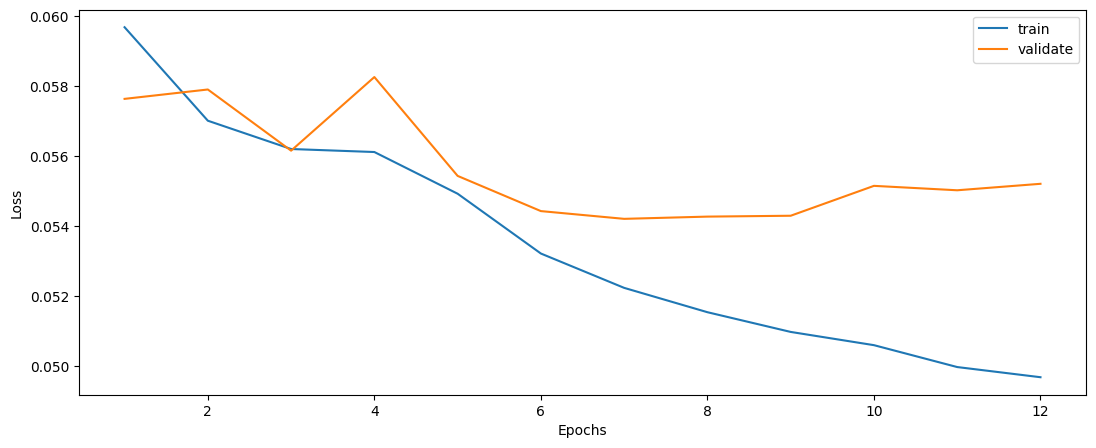

In [15]:
plot_loss(history)

### Condition 2

In [42]:
df_train_merged = pd.concat(list_df_training[2:], ignore_index=True)
df_validation_merged = pd.concat(list_df_validation[2:], ignore_index=True)
df_test_merged =pd.concat(list_df_test[2:], ignore_index=True)

df_train_merged_rul = pd.concat(list_df_training_rul[2:], ignore_index=True)
df_validation_merged_rul = pd.concat(list_df_validation_rul[2:], ignore_index=True)
df_test_merged_rul =pd.concat(list_df_test_rul[3:], ignore_index=True)

df_train_merged['RUL'] = df_train_merged_rul['RUL']
df_validation_merged['RUL'] = df_validation_merged_rul['RUL']
df_test_merged['RUL'] = df_test_merged_rul['RUL']

df_train_merged = min_max_normalize_rul_by_bearing(df_train_merged)[remaining_feature_rul]
df_validation_merged = min_max_normalize_rul_by_bearing(df_validation_merged)[remaining_feature_rul]
df_test_merged = min_max_normalize_rul_by_bearing(df_test_merged)[remaining_feature_rul]

#### Model trainig

In [45]:
from sklearn.model_selection import train_test_split

# # Assuming X and y are your feature matrix and target vector
# # Split into training (80%) and validation (20%) sets with shuffle
X_train, X_valid, y_train, y_valid = train_test_split(X_train_2, y_train_2, test_size=0.2, random_state=42, shuffle=True)

# print("X_train shape:", X_train.shape)
# print("X_valid shape:", X_valid.shape)
# print("y_train shape:", y_train.shape)
# print("y_valid shape:", y_valid.shape)

In [47]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# RMSE	std_RMSE	MSE	std_MSE	nodes	dropout	activation	batch_size	TW	time
# 0.236431	0.0	0.054317	0.0	[32]	0.2	tanh	256	40	973.954071
resultspca = pd.DataFrame()

if True:
    SEED = 1   
    set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    
    alpha = 0.10
    epochs = 30
    SEQUENCE_LENGTH = 45
    nodes_per_layer = [32]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 256
    
    # create model
    # Data prepration
    # Créer des séquences pour l’entraînement et la validation
    X_train_interim_2, X_val_interim_2, X_test_interim_2 = prep_data(train=df_train_merged[remaining_feature_idx],
                                                            val=df_validation_merged[remaining_feature_idx], 
                                                test=df_test_merged[remaining_feature_idx], 
                                                remaining_sensors=remaining_feature, 
                                                alpha=alpha, drop=False)
    X_train_interim_2.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_train_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]
    X_val_interim_2.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_validation_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]
    X_test_interim_2.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_test_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]

    X_train_interim_2 = X_train_interim_2.astype('float32')
    X_val_interim_2 = X_val_interim_2.astype('float32')
    X_test_interim_2 = X_test_interim_2.astype('float32')

    # TW values : 5 feng et al ; 35 Jie Liu 2023 ; 226 Martin et al. 2023
    X_train_2, y_train_2 = create_sequences(X_train_interim_2, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH,
                                        remaining_feature=remaining_feature)
    X_train_2, y_train_2 = X_train_2.astype(np.float32), y_train_2.astype(np.float32)

    # # Créer des séquences pour les données de test indépendantes
    # X_val_2, y_val_2 = create_sequences(X_val_interim_2, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH,
    #                                 remaining_feature=remaining_feature)
    X_train_2s, X_val_2s, y_train_2s, y_val_2s = train_test_split(X_train_2, y_train_2, test_size=0.2, random_state=42, shuffle=True)

    # Créer des séquences pour les données de test indépendantes
    X_test_2, y_test_2 = create_sequences(X_test_interim_2, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH, 
                                    remaining_feature=remaining_feature)
    # SEQUENCE_LENGTH = list_sequence_length[i]
    input_shape = (SEQUENCE_LENGTH, len(remaining_feature))    
    print(X_train_2.shape, y_train_2.shape, X_test_2.shape)
    model_2 = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
    
    optimizer = Adam(learning_rate=0.001)
    model_2.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Callback pour ajuster le learning rate
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        # weights_file = model.get_weights()
        # model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model_2.fit(X_train_2s, y_train_2s,
                                validation_data=(X_val_2s, y_val_2s),
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[reduce_lr, early_stopping],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model_2.predict(X_test_2)
        R2_val.append(r2_score(y_test_2, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(y_test_2, y_hat_val_split)))
        # score_val.append(compute_s_score(y_test, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
        #  'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : SEQUENCE_LENGTH, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    resultspca = pd.concat([resultspca, pd.DataFrame(d, index=[0])], ignore_index=True)

(360388, 45, 36) (360388,) (896328, 45, 36)
Epoch 1/30
1127/1127 [==============================] - 99s 86ms/step - loss: 0.0631 - val_loss: 0.0573 - lr: 0.0010
Epoch 2/30
1127/1127 [==============================] - 101s 90ms/step - loss: 0.0570 - val_loss: 0.0572 - lr: 0.0010
Epoch 3/30
1127/1127 [==============================] - 95s 84ms/step - loss: 0.0566 - val_loss: 0.0559 - lr: 0.0010
Epoch 4/30
1127/1127 [==============================] - 103s 91ms/step - loss: 0.0557 - val_loss: 0.0549 - lr: 0.0010
Epoch 5/30
1127/1127 [==============================] - 102s 91ms/step - loss: 0.0545 - val_loss: 0.0532 - lr: 0.0010
Epoch 6/30
1127/1127 [==============================] - 110s 98ms/step - loss: 0.0529 - val_loss: 0.0517 - lr: 0.0010
Epoch 7/30
1127/1127 [==============================] - 113s 100ms/step - loss: 0.0512 - val_loss: 0.0497 - lr: 0.0010
Epoch 8/30
1127/1127 [==============================] - 125s 111ms/step - loss: 0.0499 - val_loss: 0.0480 - lr: 0.0010
Epoch 9/30
1

ValueError: Input contains NaN.

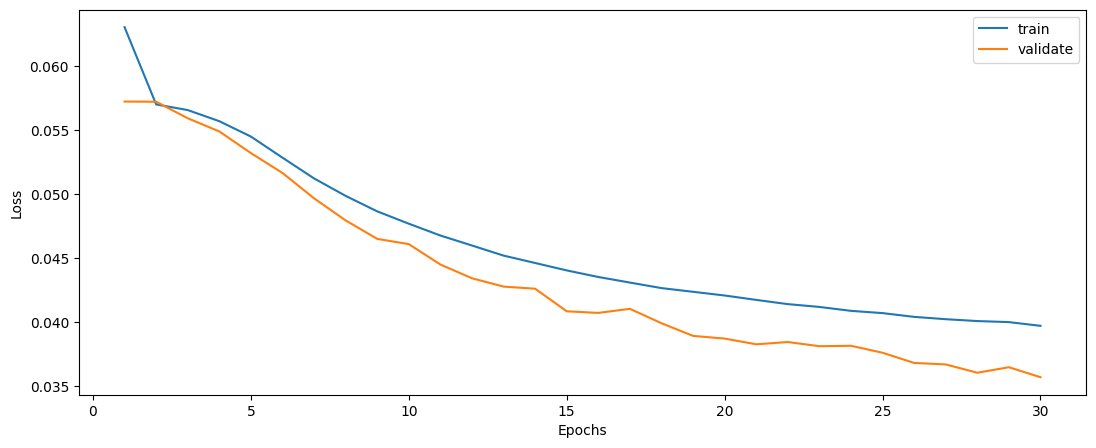

In [50]:
plot_loss(history)

In [53]:
y_hat_val_split = model_2.predict(X_val_2s)

2253/2253 [==============================] - 7s 3ms/step


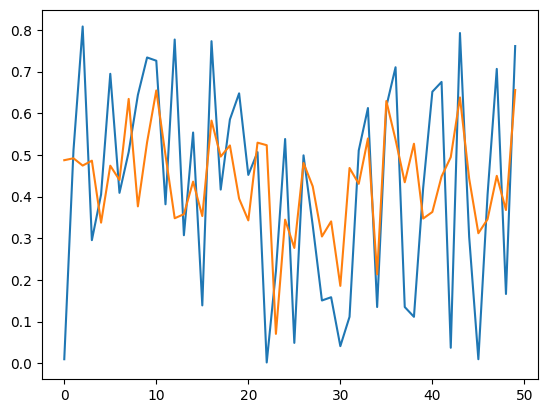

In [56]:
plt.plot(y_val_2s[:50])
plt.plot(y_hat_val_split[:50])

### Model PCA

#### Data prepraration

In [ ]:
df_train_merged = pd.concat(list_df_training[2:], ignore_index=True)
df_validation_merged = pd.concat(list_df_validation[2:], ignore_index=True)
df_test_merged =pd.concat(list_df_test[3:], ignore_index=True)

df_train_merged_rul = pd.concat(list_df_training_rul[0:2], ignore_index=True)
df_validation_merged_rul = pd.concat(list_df_validation_rul[0:2], ignore_index=True)
df_test_merged_rul =pd.concat(list_df_test_rul[0:2], ignore_index=True)

df_train_merged['RUL'] = df_train_merged_rul['RUL']
df_validation_merged['RUL'] = df_validation_merged_rul['RUL']
df_test_merged['RUL'] = df_test_merged_rul['RUL']

df_train_merged = min_max_normalize_rul_by_bearing(df_train_merged)
df_validation_merged = min_max_normalize_rul_by_bearing(df_validation_merged)
df_test_merged = min_max_normalize_rul_by_bearing(df_test_merged)

In [ ]:
X_train_interim, X_val_interim, X_test_interim = prep_data(train=df_train_merged[remaining_feature_idx],
                                                            val=df_validation_merged[remaining_feature_idx], 
                                                test=df_test_merged[remaining_feature_idx], 
                                                remaining_sensors=remaining_feature, 
                                                alpha=alpha, drop=False)

In [ ]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# RMSE	std_RMSE	MSE	std_MSE	nodes	dropout	activation	batch_size	TW	time
# 0.236431	0.0	0.054317	0.0	[32]	0.2	tanh	256	40	973.954071
results001 = pd.DataFrame()

if True:
    SEED = 1   
    set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    
    alpha = 0.10
    epochs = 25
    SEQUENCE_LENGTH = 45
    nodes_per_layer = [32]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 256
    
    # create model
    # Data prepration
    # Créer des séquences pour l’entraînement et la validation
    X_train_interim, X_val_interim, X_test_interim = prep_data(train=df_train_merged[remaining_feature_idx],
                                                            val=df_validation_merged[remaining_feature_idx], 
                                                test=df_test_merged[remaining_feature_idx], 
                                                remaining_sensors=remaining_feature, 
                                                alpha=alpha, drop=False)
    X_train_interim.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_train_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]
    X_val_interim.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_validation_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]
    X_test_interim.loc[:, ['bearing_id', 'window_index', 'RUL_norm']] = df_test_merged.loc[:, ['bearing_id', 'window_index', 'RUL_norm']]

    X_train_interim = X_train_interim.astype('float32')
    X_val_interim = X_val_interim.astype('float32')
    X_test_interim = X_test_interim.astype('float32')
    
        #PCA data reduction 
    X_cr_train, X_cr_test= StandardScaler().fit_transform(X_train_interim[remaining_sensors]), StandardScaler().fit_transform(X_test_interim[remaining_sensors])
    pca = PCA()
    component_train , component_test = pca.fit(X_cr_train).transform(X_cr_train), pca.transform(X_cr_test)
    # print(pca.explained_variance_, np_component) # choos component which lambda >1 # kaiser

    np_component = len(remaining_feature)
    print(pca.explained_variance_,'\n', "Nb components: ", np_component) # choos component which lambda >1 # kaiser
    comp = ['comp' + str(i) for i in range(1,np_component+1)]
    X_train_interim[comp],  X_test_interim[comp]= component_train[:, :np_component], component_test[:, :np_component]

    # TW values : 5 feng et al ; 35 Jie Liu 2023 ; 226 Martin et al. 2023
    X_train, y_train = create_sequences(X_train_interim, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH,
                                        remaining_feature=remaining_feature)
    X_train, y_train = X_train.astype(np.float32), y_train.astype(np.float32)

    # Créer des séquences pour les données de test indépendantes
    X_val, y_val = create_sequences(X_val_interim, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH,
                                    remaining_feature=remaining_feature)

    # Créer des séquences pour les données de test indépendantes
    X_test, y_test = create_sequences(X_test_interim, target_col='RUL_norm', sequence_length=SEQUENCE_LENGTH, 
                                    remaining_feature=remaining_feature)
    # SEQUENCE_LENGTH = list_sequence_length[i]
    input_shape = (SEQUENCE_LENGTH, len(remaining_feature))    
    print(X_train.shape, y_train.shape, X_test.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Callback pour ajuster le learning rate
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        # weights_file = model.get_weights()
        # model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[reduce_lr, early_stopping],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(X_test)
        R2_val.append(r2_score(y_test, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(y_test, y_hat_val_split)))
        # score_val.append(compute_s_score(y_test, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
        #  'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : SEQUENCE_LENGTH, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results001 = pd.concat([results001, pd.DataFrame(d, index=[0])], ignore_index=True)